In [30]:
import numpy as np
import geopandas as gpd
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from matplotlib.colors import LogNorm
from matplotlib.cm import ScalarMappable
import matplotlib.animation as animation

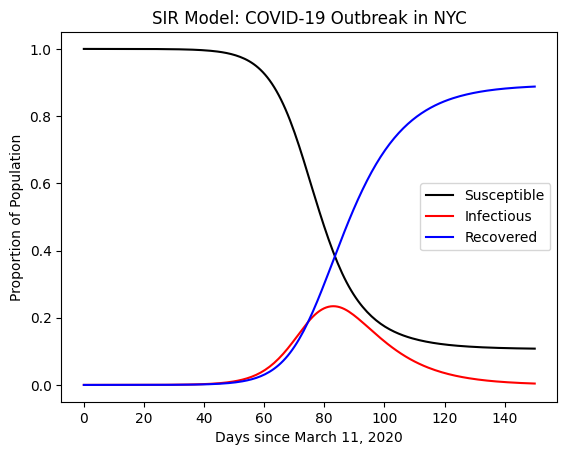

In [31]:
def ode(t, y):
    
    # Parameters
    gamma, B = 1/10, 2.5/10
    
    # Solve ODE System
    S, I, R = y[0], y[1], y[2]
    return np.array([(-B * I * S), (B * I * S) - gamma * I, gamma * I])


# ODE Parameters
y0 = np.array([8399000-52, 52, 0]) / 8399000
t0, tf = 0, 150
t_vals = np.linspace(t0, tf, 200) 
# Solve SIR System
sol = solve_ivp(ode, (t0, tf), y0, t_eval=t_vals)

# Plot Results
plt.plot(sol.t, sol.y[0], color='black', label='Susceptible')
plt.plot(sol.t, sol.y[1], color='red', label='Infectious')
plt.plot(sol.t, sol.y[2], color='blue', label='Recovered')
plt.xlabel("Days since March 11, 2020")
plt.ylabel("Proportion of Population")
plt.title("SIR Model: COVID-19 Outbreak in NYC")
plt.legend()
plt.show()

alpha: 1.9518002952703022, T_G: 58.4853938287099


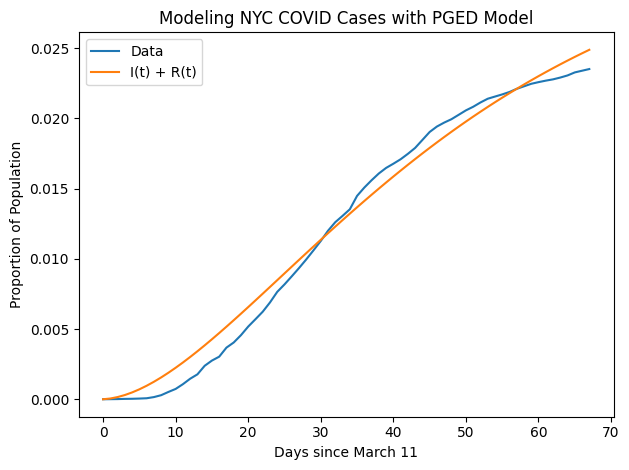

In [32]:
# Load
data = np.load("new_york_cases.npy")
ys = [count / 8399000 for count in data]

# Solve ODE System
def ode(t, y, a, TG):
    I = y[1]
    return np.array([(-a / t) * I, (( a / t) - (1 / TG)) * I, (1 / TG) * I])

# Search for Optimal Parameters
def calculate_error(params):
    
    # Parameters
    a, TG = params
    t0, tf = 1, 150
    t_vals = np.linspace(t0, tf, len(ys)) 

    # Solve IVP
    y0 = np.array([8399000 - 52, 52, 0]) / 8399000
    sol = solve_ivp(lambda t,y: ode(t, y, a, TG), (t0, tf), y0, t_eval=t_vals)

    # Error Difference
    diff = (sol.y[1] + sol.y[2]) - ys

    return np.linalg.norm(diff)

# Find Optimal Parameters
p0 = (1, 1)
result = minimize(calculate_error, p0)
a, TG = result.x[0], result.x[1]
print(f"alpha: {a}, T_G: {TG}")

# Solve ODE with Optimal Parameters
t_vals = np.linspace(1, 150, len(ys)) 
y0 = np.array([8399000-52, 52, 0]) / 8399000
sol = solve_ivp(lambda t,y: ode(t, y, a, TG), (1, 150), y0, t_eval=t_vals)

# Plot Results
plt.plot(ys, label='Data')
plt.plot(sol.y[1] + sol.y[2], label='I(t) + R(t)')
plt.title("Modeling NYC COVID Cases with PGED Model")
plt.xlabel("Days since March 11")
plt.ylabel("Proportion of Population")
plt.legend()
plt.tight_layout()
plt.show()

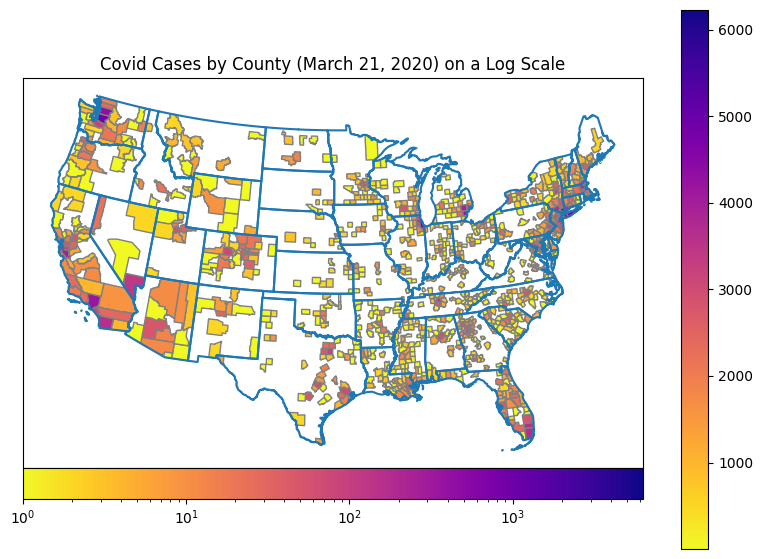

In [33]:
# Load Data
nytimes = pd.read_csv("nytimes.csv") 
counties = gpd.read_file("county_data.gpkg") 

# Calculate fips Values for Counties
counties["fips"] = (counties["STATEFP"] + counties["COUNTYFP"]).astype(float)

# Drop STATEFP Codes and Modify CRS Attribute
counties = counties[~(counties["STATEFP"].isin(['02', '15', '60', '66', '69', '72', '78']))]
counties.to_crs(5071, inplace=True)
# Plot State Outline Map
countiesDissolved = counties.dissolve(by="STATEFP") # aggfunc?

# Merge Counties and Nytimes Data
merged = counties.merge(nytimes, on="fips")

# Plot March 21, 2020 Cases
fig, ax = plt.subplots(1, figsize=(10, 7))
filtered_merged = merged[merged['date'] == '2020-03-21'] 
filtered_merged.plot(ax=ax, cmap='plasma_r', legend=True, column='cases')

# Plot Graph using the Log Norm
norm = LogNorm(vmin=min(filtered_merged['cases']), vmax=max(filtered_merged['cases']))
countiesDissolved.boundary.plot(ax=ax)
filtered_merged.plot(column="cases", cmap="plasma_r", ax=ax, edgecolor="gray", norm=norm)
# Create Colorbar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap="plasma_r"), ax=ax, orientation="horizontal", pad=0) 
ax.set_title("Covid Cases by County (March 21, 2020) on a Log Scale")
ax.set_yticks([])
ax.set_xticks([])
plt.show()

In [34]:
plt.ioff()

fig, ax = plt.subplots(1, figsize=(10, 7))
norm = LogNorm(vmin=min(filtered_merged['cases']), vmax=max(filtered_merged['cases']))

def update(date):
    ax.clear()
    # Plot the cases by county from the specified date
    filtered_merged = merged[merged['date'] == date] 
    filtered_merged.plot(column="cases", cmap="plasma_r", ax=ax, edgecolor="gray", norm=norm)
    # Plot the State Outlines
    countiesDissolved.boundary.plot(ax=ax)

    # Add Date Label
    ax.text(0.02, 0.95, date, transform=ax.transAxes, fontsize=12, 
            verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
    
    # Add Title
    ax.set_title("Spread of Covid-19 through US counties from 1/21/2020-6/21/2020")
    
# Set up the colorbar
cbar = fig.colorbar(ScalarMappable(norm=norm, cmap="plasma_r"), ax=ax, orientation="horizontal", pad=0)

# Create animation object
ani = animation.FuncAnimation(fig, update, 
        frames=sorted(set(merged['date'])),
        interval=1000*(1/30)) # Each frame is 1/30 of a second
plt.close(fig)

In [35]:
# Save / Embed Animation
animation.writer = animation.writers['ffmpeg']
ani.save('covid_spread.mp4')

<video src="covid_spread.mp4" controls>